# Examples taken from the Elements of SMC paper

In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from sequential_monte_carlo import NonMarkovianSM

In [5]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
jnp.set_printoptions(suppress=True)

$\newcommand{\normal}[3]{{ \mathcal{N}\left(#1 \vert #2, #3\right) }}$

We model a non-Markovian Gaussian sequence model as follows

$$
\begin{aligned}
    p(x_t \vert x_{t-1}) &= \normal{x_t}{\phi x_{t-1}}{q} \\
    p(y_t \vert x_{1:t}) &= \normal{y_t}{\sum_{k=1}^t \beta^{t-k}x_k}{r}
\end{aligned}
$$

To sample from $p(y_t \vert x_{1:t})$, note that

* at $t=1$, $\mathbb{E}[y_1] = x_1$
* at $t=2$, $\mathbb{E}[y_2] = \beta x_1 + x_2$
* at $t=3$, $\mathbb{E}[y_3] = \beta^2 x_1 + \beta x_2 + x_3$,

and so on.

We can rewrite this sequence recursively introducing a new variable $\mu_t$ defined as

$$
    \mu_t = \beta \mu_{t-1} + x_t,
$$

with $\mu_1 = x_1$. We obtain

* at $t=1$, $\mathbb{E}[y_1] = x_1 = \mu_1$
* at $t=2$, $\mathbb{E}[y_2] = \beta x_1 + x_2 = \beta \mu_1 + x_2 = \mu_2$
* at $t=3$, $\mathbb{E}[y_3] = \beta \mu_2 + x_3 = \mu_3$
* at $t=4$, $\mathbb{E}[y_4] = \beta \mu_3+ x_4$.

More generally,

* at $t=\tau$, $\mathbb{E}[y_\tau] = \beta\mu_{\tau - 1} + x_{\tau}$.


Hence, we rewrite the sequence model as follows

$$
\begin{aligned}
    p(x_t \vert x_{t-1}) &= \normal{x_t}{\phi x_{t-1}}{q} \\
    p(y_t \vert \mu_{t-1}, x_{t}) &= \normal{y_t}{\beta \mu_{t-1} + x_t}{r}
\end{aligned}
$$

## Example

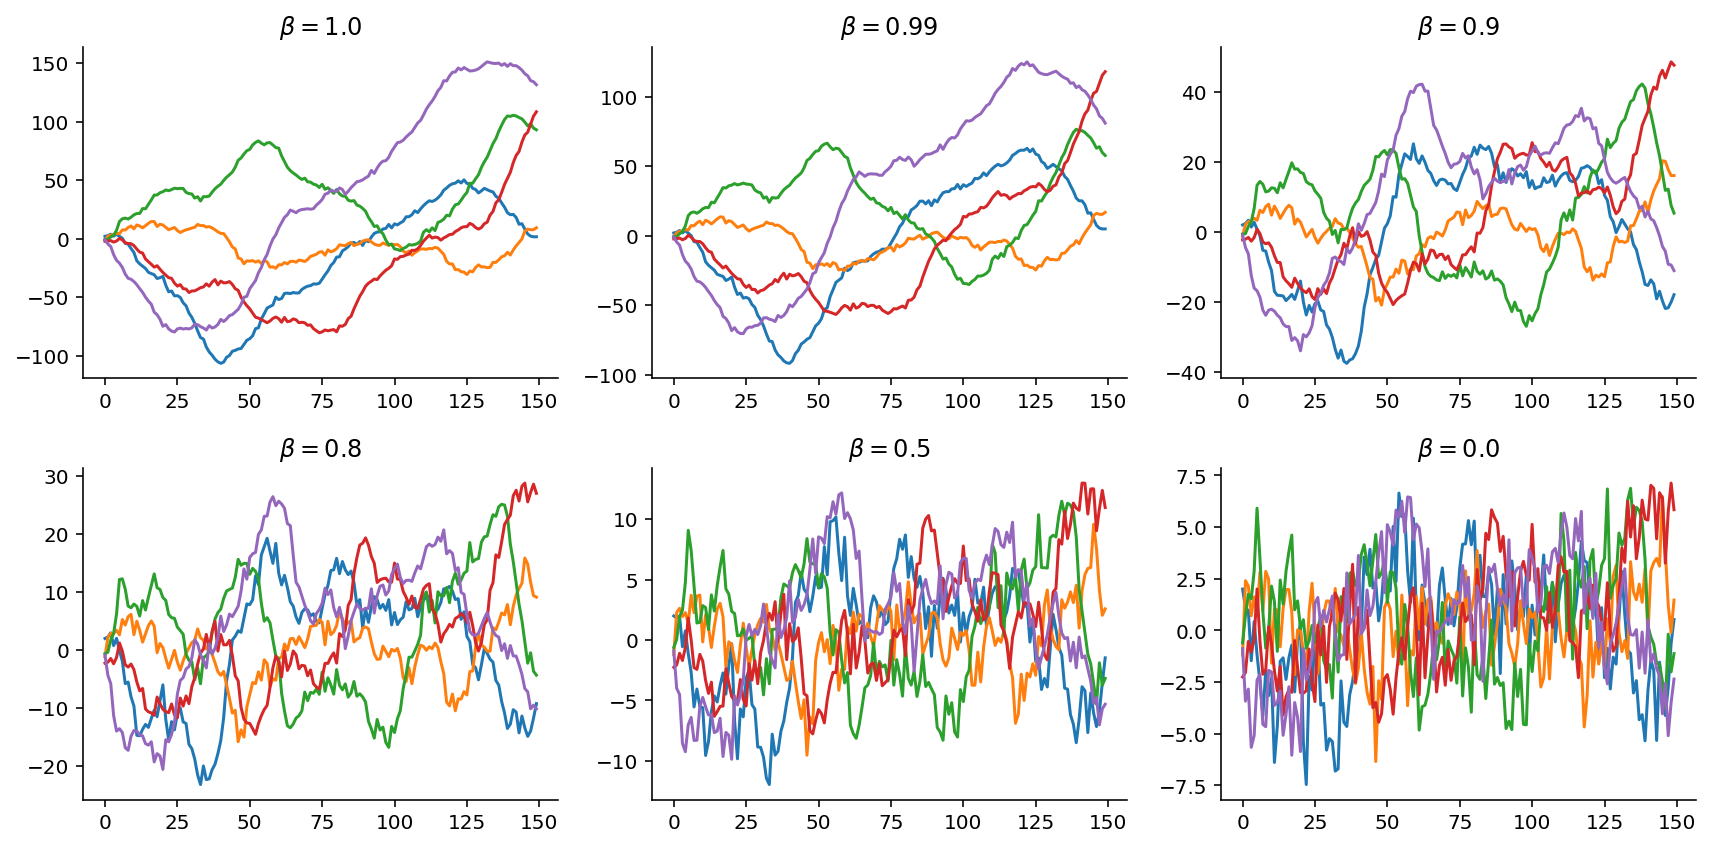

In [7]:
beta_values = jnp.array([1.0, 0.99, 0.9, 0.8, 0.5, 0])
phi, q, r = 0.9, 1.0, 1.0
T = 150

key = jax.random.PRNGKey(314)
fig, ax = plt.subplots(2, 3, figsize=(12, 6))
ax = ax.ravel()

for axi, beta in zip(ax, beta_values):
    seq_model = NonMarkovianSM(phi, beta, q, r)
    hist = seq_model.sample(key, T, 5)
    for simul_y in hist["y"]:
        axi.plot(simul_y)
        axi.set_title(rf"$\beta={beta:0.2}$")
plt.tight_layout()

## Sequential Importance Sampling (SIS)

* Variant of IS where the proposal distribution has an autoregressive structure. The weights are computed recursively.

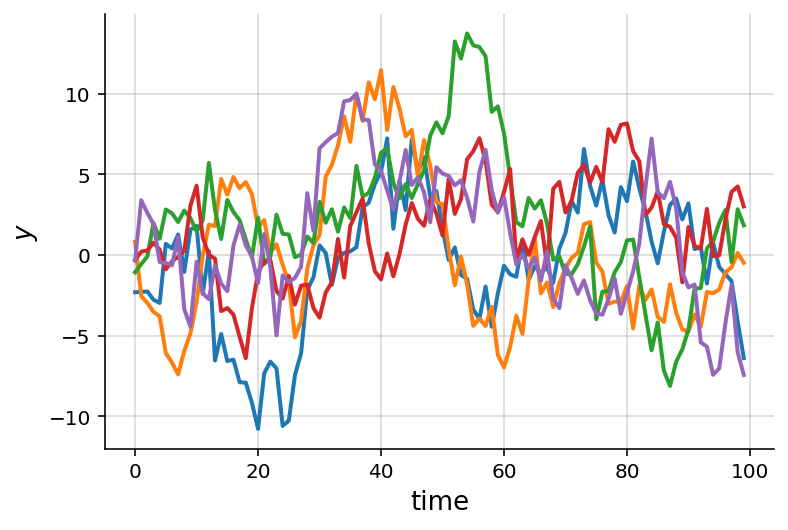

In [8]:
key = jax.random.PRNGKey(314)


phi, q, beta, r = 0.9, 1.0, 0.5, 1.0
seq_model = NonMarkovianSM(phi, beta, q, r)
hist_target = seq_model.sample(key, 100, 5)
observations = hist_target["y"]

for sample in hist_target["y"]:
    plt.plot(sample, linewidth=2)
    
plt.xlabel("time", fontsize=13)
plt.ylabel("$y$", fontsize=13)
plt.grid(alpha=0.5)

In [9]:
key = jax.random.PRNGKey(3141)
key_sample, key_filter = jax.random.split(key)
seq_model = NonMarkovianSM(phi, beta, q, r)
hist_target = seq_model.sample(key_sample, 100)
observations = hist_target["y"]
log_unnormalised_weights = seq_model.sequential_importance_sample(key_filter, observations, n_particles=5)
weights = jnp.exp(log_unnormalised_weights - jax.nn.logsumexp(log_unnormalised_weights, axis=1, keepdims=True))

weights[:10]

DeviceArray([[0.21723284, 0.23567332, 0.00775659, 0.32000393, 0.21933341],
             [0.14110507, 0.00285448, 0.00004199, 0.51208836, 0.34391022],
             [0.15424863, 0.00012387, 0.00000025, 0.5002884 , 0.34533888],
             [0.14529419, 0.00025059, 0.00000052, 0.8332753 , 0.02117944],
             [0.00068706, 0.00086053, 0.0000006 , 0.99845195, 0.00000012],
             [0.02295148, 0.00011859, 0.00002003, 0.9769068 , 0.00000345],
             [0.07558708, 0.00000167, 0.00010792, 0.9242854 , 0.00001792],
             [0.6421226 , 0.00000421, 0.00220953, 0.35453263, 0.00113181],
             [0.9705041 , 0.00001276, 0.01131476, 0.0119412 , 0.00622659],
             [0.9977747 , 0.00000326, 0.00006489, 0.00000019, 0.00215606]],            dtype=float32)

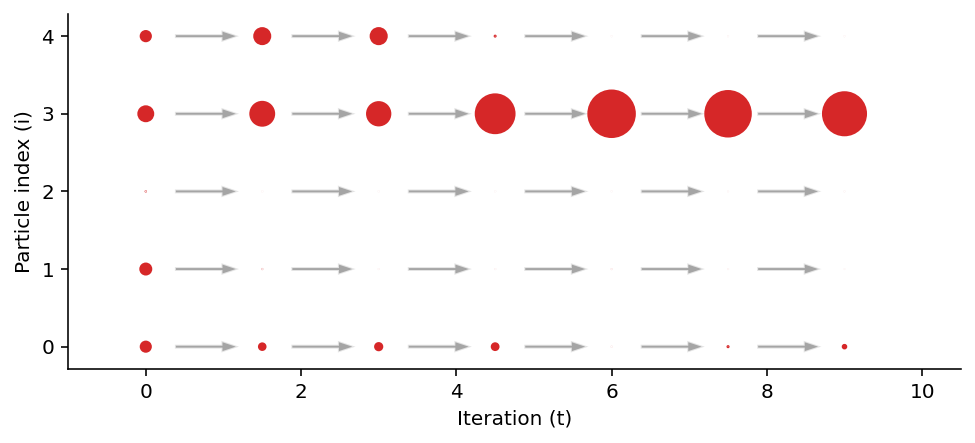

In [10]:
norm_cst = weights[0].sum()


n_steps = 7
spacing = 1.5
radii = 1 * weights[0] / norm_cst

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_aspect(1)
for col, weights_row in enumerate(weights[:n_steps]):
    norm_cst = weights_row.sum()
    radii = weights_row / norm_cst * 0.3
    for row, rad in enumerate(radii):
        if col != n_steps - 1:
            plt.arrow(spacing * (col + 0.25), row, 0.6, 0, width=0.05, edgecolor="white", facecolor="tab:gray", alpha=0.7)
        circle = plt.Circle((spacing * col, row), rad, color="tab:red")
        ax.add_artist(circle)



plt.xlim(-1, n_steps * spacing)
plt.xlabel("Iteration (t)")
plt.ylabel("Particle index (i)")
plt.xticks();

# Sequential Monte Carlo (SMC)
## SCM ≡ SIR ≡ SISR